In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

Part 1 - EDA

In [2]:
df=pd.read_json('logins.json')

In [3]:
df.sample(5)

,login_time
30626,1970-02-13 08:41:16
67134,1970-03-20 10:22:37
57302,1970-03-12 21:41:32
48036,1970-03-03 11:39:20
47641,1970-03-02 19:54:27


In [4]:
df.set_index('login_time', inplace=True)
df.loc[:,'logins']=1

In [5]:
df.sample(5)

,logins
login_time,
1970-02-21 14:07:34,1
1970-04-05 02:40:33,1
1970-02-22 16:45:51,1
1970-03-30 11:44:42,1
1970-03-05 22:37:06,1


In [6]:
df.index.min(),df.index.max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

In [7]:
#resample time series data to a 15-minute frequency, calculate the number of login within each 15-minute interval
df_agg=df.resample('15min').sum()
df_agg.sample(5)

,logins
login_time,
1970-02-27 03:30:00,8
1970-03-20 12:30:00,22
1970-01-16 11:45:00,19
1970-02-09 14:45:00,6
1970-01-22 06:00:00,1


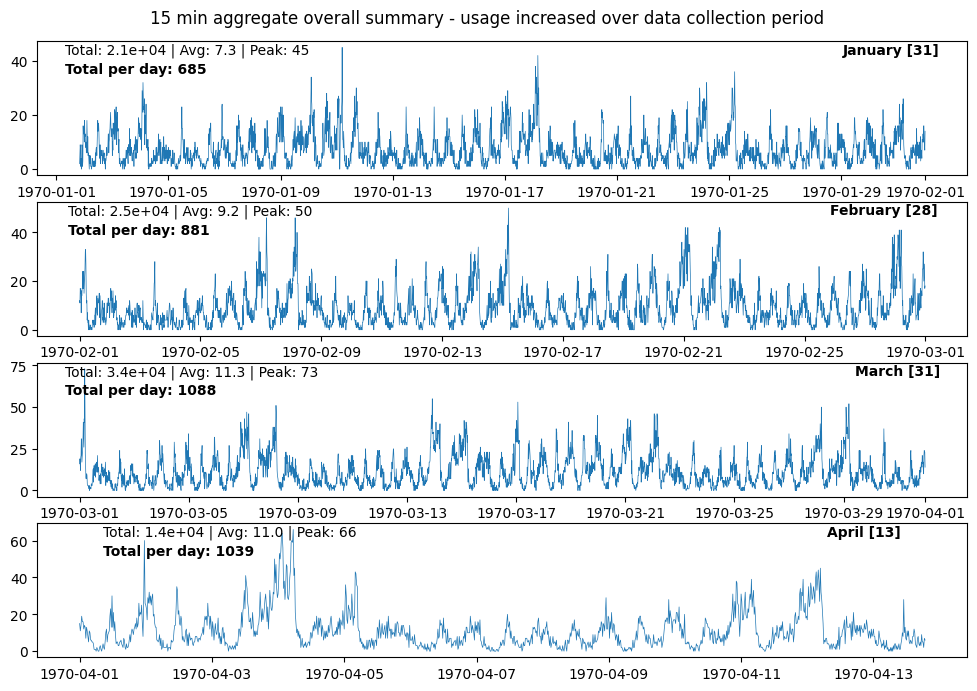

In [8]:
plt.figure(figsize=(12,8))

for i in range(4):
    plt.subplot(4,1,i+1)
    pdata = df_agg[df_agg.index.month==i+1]
    plt.plot(pdata,'-', linewidth=0.5)
    xb = plt.xlim()
    yb = plt.ylim()
    plt.text(xb[1]-1, yb[1]*0.9, f'{pdata.index[0].month_name()} [{pdata.index.day.unique().shape[0]}]',
             ha='right', fontweight='bold')
    plt.text(xb[0]+1, yb[1]*0.9,
             f'Total: {pdata.sum().values[0]:.1e} | Avg: {pdata.mean().values[0]:.1f} | Peak: {pdata.max().values[0]}',
            fontweight='normal')
    plt.text(xb[0]+1, yb[1]*0.75,
         f'Total per day: {pdata.sum().values[0]/pdata.index.day.unique().shape[0]:.0f}',
        fontweight='bold')
plt.suptitle('15 min aggregate overall summary - usage increased over data collection period', y=.92)
plt.show()

Trend: overall: number of logins generally increased over time (March has more login than Jan, Feb etc)

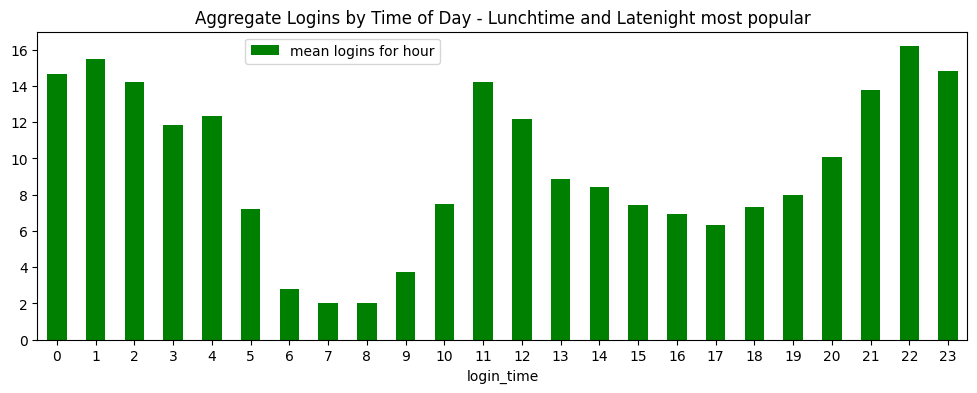

In [9]:
fig, axs = plt.subplots(figsize=(12, 4))

df_agg.groupby(df_agg.index.hour).mean().plot(
    kind='bar', rot=0, ax=axs, color='g',
)


plt.legend(['mean logins for hour'], bbox_to_anchor=(0.44,1))
plt.title('Aggregate Logins by Time of Day - Lunchtime and Latenight most popular')
plt.show()

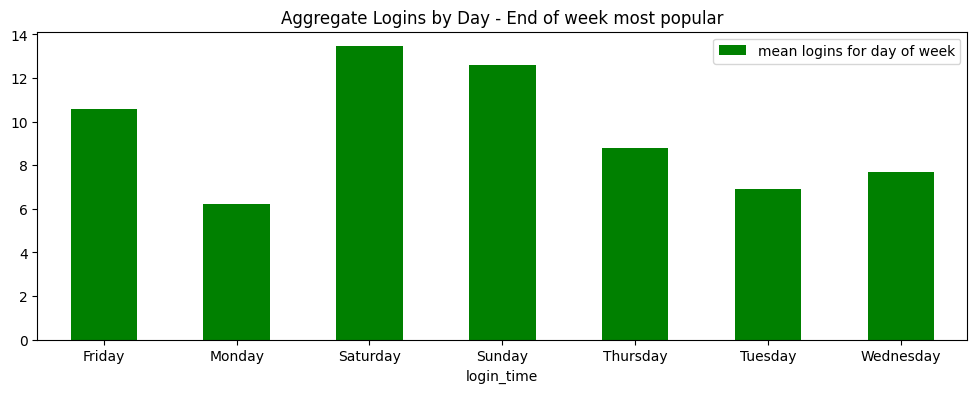

In [10]:
#locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
fig, axs = plt.subplots(figsize=(12, 4))

#df_agg.groupby(df_agg.index.day_name(locale='en_US.utf8')).mean().plot()
df_agg.groupby(df_agg.index.day_name(locale=None)).mean().plot(
    kind='bar', rot=0, ax=axs, color='g',
)



plt.legend(['mean logins for day of week'])
plt.title('Aggregate Logins by Day - End of week most popular')
plt.show()

TREND: Time of day is important
one midday peak around 11-12, but most popular usage late at night/early morning. 21-24 and 0-4
Friday, Saturday, Sunday are the busiest with more logints than other days


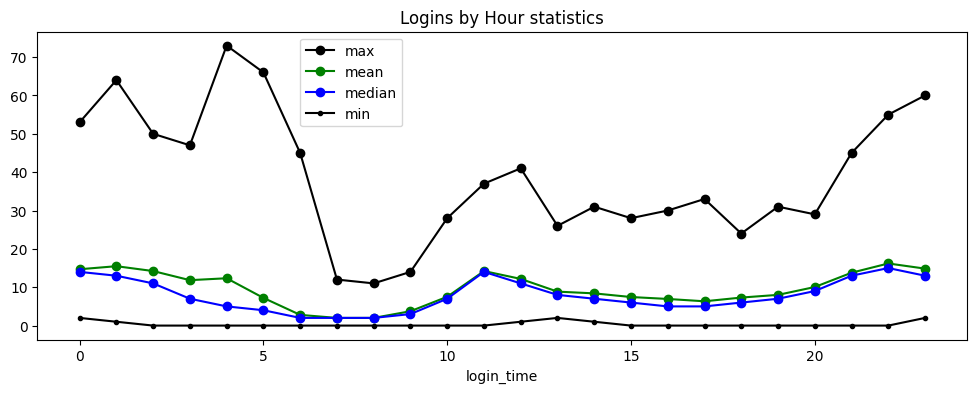

In [11]:
#Extra plots - stats for hourly login
fig, axs = plt.subplots(figsize=(12, 4))

df_agg.groupby(df_agg.index.hour).max().plot(
    kind='line', rot=0, ax=axs, color='k', marker='o',
)
df_agg.groupby(df_agg.index.hour).mean().plot(
    kind='line', rot=0, ax=axs, color='g', marker='o',
)

df_agg.groupby(df_agg.index.hour).median().plot(
    kind='line', rot=0, ax=axs, color='b', marker='o',
)
df_agg.groupby(df_agg.index.hour).min().plot(
    kind='line', rot=0, ax=axs, color='k', marker='.',
)

plt.legend(['max','mean','median','min'], bbox_to_anchor=(0.4,1))
plt.title('Logins by Hour statistics')
plt.show()

PART 2 - Experimental Metrics and Design 

a. Measure of Success: Increase in tolled rides vs cost of reimbursement.
characterize each ride with 0 for no commute or 1 for at least a one-way bridge crossing. determine baseline fraction of tolled rides for a given time period before the experimental window.
as shown above (EDA), various aggregate trends should be noted for better comparisons
this measure will be simple and be most direct in terms of desired outcome
reimbursement cost should also be considered, and the baseline tolled rides rate can be used for adjustment
for a starting experiment, simple metrics and success critieria may be more helpful than trying to optimize something without understanding it
for example, trying to measure rides in certain directions or at certain times of day should wait until future experiments

b. Implementation
for one "promotional" month, Ultimate will reimburse all tolls between Gotham and Metropolis on weekdays
the above mentioned metric will be determined for the experiment window


c. Interpretation
null hypothesis
tolled rides will not increase during the experimental window, therefore showing tolls may not be the only reason drivers choose not to commute between the cities.
if the results do not confirm the null hypothesis, then the experiment indicates that reimbursing tolls contributed to increased rides between the two cities. it will also be valuable to see if there were any differences in tolled rides on the weekends, during which tolls were unaffected by the experiment.

d. Recommendations to City Operations
assumptions/background: I am imagining being a stakeholder for the company who would want the cities to promote driving as much as possible. It's possible city operators are satisfied with the toll's effects on commuters and choices for transportation, and worth learning more about their motivations. I will assume that there was a significant increase in tolled rides during the experimental window, and even indications that tolled rides increased on the weekends.
communicate results
increased intercity commutes, gained economic opportunity for each city with more population mixing
note cost Ultimate reimbursed in Toll Fees, and how much was estimated to be "above baseline"
be transparent about imbalanced flow and patterns of occurence. for example, it is likely most of the afternoon/evening traffic will be from Metroplis to Gotham
if alternative public transportation is available, note possible spikes in Ultimate ridership after closing. for example, sample login data showed high usage between 12am and 2am
propose toll reduction options (this feels aggressive)
cities remove toll outside of main commuting window and on weekends
could keep exceptions for special events / holidays
Ultimate reimburses users full-price of tolls at all other times, and city agrees to provide Ultimate with a rebate for half of its reimbursements
users will effectively have no toll, and Ultimate will take on half the cost and initially, the full payment to the city
decreased toll revenues to cities should be justified with other estimated benefits, communicated with the results
caveats
depending on the balance of commutes, it may make more sense to for the toll to have a scheduled cost with direction of travel taken into account
the cities may not want to equally lose revenue. Gotham may see more benefit from increased commuting, if most users are leaving Metropolis
fully removing the toll may not be necessary to encourage more use of the bridge


PART 3 - Modeling

predict rider retention. sample dataset has riders who signed up in Jan 2014 and whether they took a ride within the next several months.
use data to determine factors import to retention and provide suggestions for company to use them
cleaning, EDA, visualizations for data. minimal word descriptions necessary. what fraction of sampled users were retained?
answer: 37.6% | cleaning / target definition
build predictive model to determine if user will be active (with?)in their 6th month. discuss choices, validity, and indicators of performance
see model selection | model evaluation
describe how company can use insights to improve long-term retention
see results and interpretations

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, scale
# from sklearn.feature_selection import SelectKBest # manually removed some features, will not pare down further
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, \
                            auc, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from scipy import stats

from tqdm import tqdm
from time import time

In [13]:
def score_pred(true, pred):
    return {
        'accuracy': round(accuracy_score(true,pred),3),
        'balanced_accuracy': round(balanced_accuracy_score(true,pred),3),
        'precision': round(precision_score(true,pred),3),
        'recall': round(recall_score(true,pred),3),
        'f1': round(f1_score(true,pred),3),
        'roc_auc': round(roc_auc_score(true,pred),3),
    }

Cleaning, Target Definition
- 3 different cities
- convert date dtypes
-define target
    user is "retained" if they took ride in preceding 30 days. will assume data was pulled at latest last_trip_date
    data pulled on 2014-07-01 | d.last_trip_date.max()
    user retained if last_trip_date on 2014-06-01 or later | d.last_trip_date.max()-pd.Timedelta('30 days')

In [14]:
df1 = pd.read_json('ultimate_data_challenge.json')
# df1.info()

In [15]:
for col in ['signup_date', 'last_trip_date']:
    df1[col] = pd.to_datetime(df1.loc[:,col])

In [16]:
# target variable: retained = took trip within last 30 days.
df1.loc[:,'retained'] = df1.last_trip_date >= (df1.last_trip_date.max()-pd.Timedelta('30 days'))

In [17]:
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


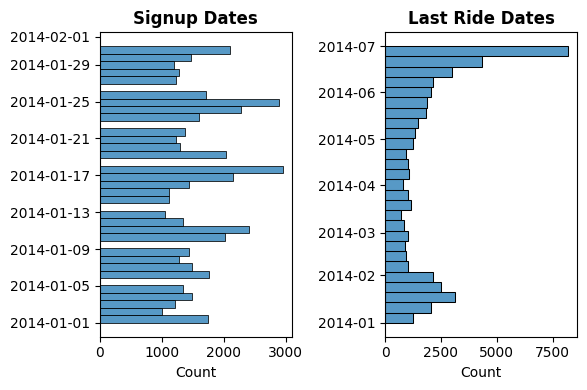

In [18]:
plt.figure(figsize=(6,4), tight_layout=True)
plt.subplot(121)
sns.histplot(y=df1.signup_date)
plt.ylabel('')
plt.title('Signup Dates', fontweight='bold')
plt.subplot(122)
sns.histplot(y=df1.last_trip_date)
plt.ylabel('')
plt.title('Last Ride Dates', fontweight='bold')
plt.show()

/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6247/1451036733.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1.retained, palette='turbo_r')


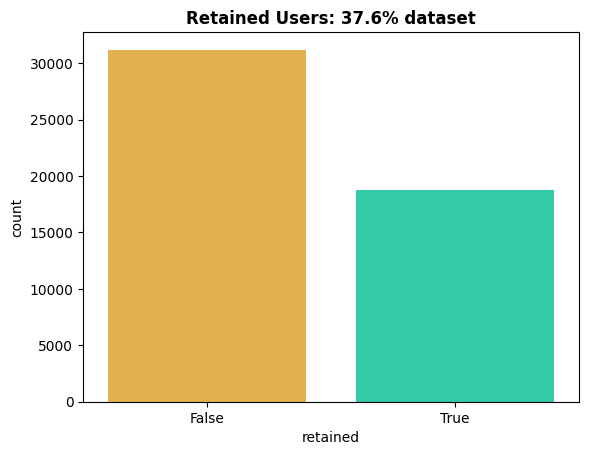

In [19]:
sns.countplot(x=df1.retained, palette='turbo_r')
plt.title(f'Retained Users: {100*df1.retained.mean():.1f}% dataset',
          fontweight='bold')
plt.show()

#Target, Feature Relationships
-signup_date | no relation
    checked by day of week, too
-city | riders who signed up from King's Landing had much higher retention rate, Winterfell had the most total riders and retained riders
- trips_in_first... | normally distributed above 0
    most of dataset had between 0-4 in rides in first 30 days, and retention rate was low/population average
    a few riders had 5 or greater rides in the first 30 days, and retention rate was about double the population average
- phone | iPhone,Android,None
    iPhone has higher retention rate than other two, more users
- ultimate_black_user
    less common, but higher retention rate
- numerical
    slight correlation with ultimate_black_user and trips in first month with retention, as noted above
    other features show little correlation with target, but some intercorrelation
        avg surge, surge pct are highly intercorrelated, as they have similar definitions and meanings
        rides on weekdays might tend to be longer distances
        drivers may rate riders slightly better on longer drives

In [20]:
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


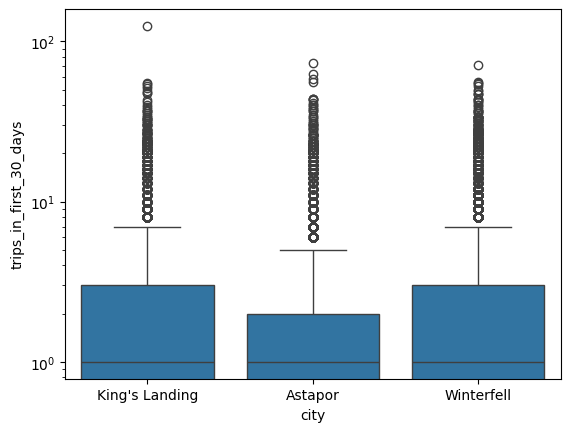

In [21]:
#Check Feature Relations - used cells to check various feature pairs
sns.boxplot(df1,x='city',y='trips_in_first_30_days')
plt.yscale('log')

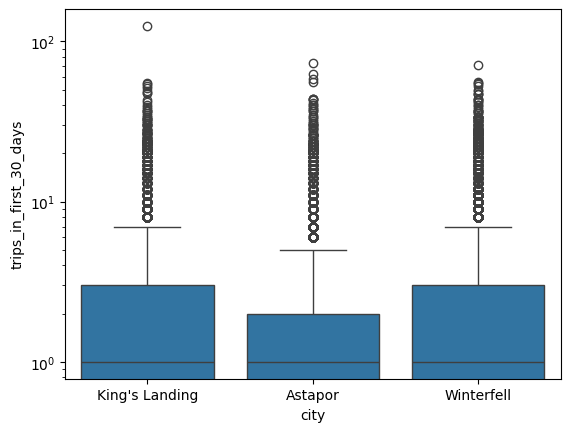

In [22]:
#Check feature relations - used cells to check various feature pairs
sns.boxplot(df1,x='city',y='trips_in_first_30_days')
plt.yscale('log')

In [23]:
c1 = 'city'
c2 = 'trips_in_first_30_days'

for c1_v in df1[c1].unique():
    print(c1_v, c2, str(df1[df1[c1]==c1_v][c2].mean().round(2)).rjust(27-len(str(c1_v))))
    #print(c1_v, c2, str(df1[df1[c1]==c1_v][c2].mean().round(2)))

King's Landing trips_in_first_30_days          2.46
Astapor trips_in_first_30_days                 1.95
Winterfell trips_in_first_30_days              2.43


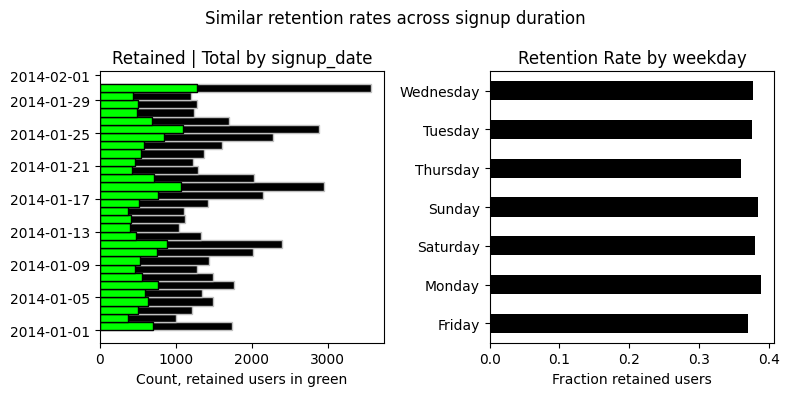

In [24]:
#signup date
plt.figure(figsize=(8,4), tight_layout=True)
plt.subplot(121)
plt.hist(x = df1.signup_date, orientation='horizontal',
         color='k', edgecolor='silver', bins=np.sort(df1.signup_date.unique()))
plt.hist(x = df1[df1.retained==True].signup_date, orientation='horizontal',
         color='lime', edgecolor='k', bins=np.sort(df1.signup_date.unique()))
plt.title('Retained | Total by signup_date')
plt.xlabel('Count, retained users in green')
plt.subplot(122)
df1.groupby(df1.signup_date.dt.day_name(locale=None)).retained.mean().plot(kind='barh', rot=0, color='k',)
plt.title('Retention Rate by weekday')
plt.ylabel('')
plt.xlabel('Fraction retained users')
plt.suptitle('Similar retention rates across signup duration')

plt.show()

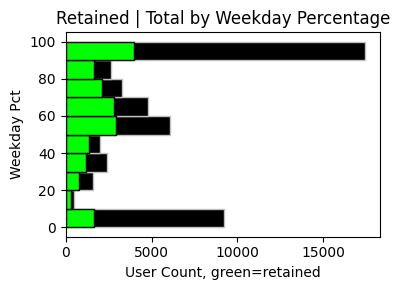

In [25]:
#retained rate by weekly% weekday_pct
plt.figure(figsize=(4,3), tight_layout=True)
plt.hist(x = df1.weekday_pct, orientation='horizontal',
         color='k', edgecolor='silver', bins=np.arange(0,110,10))
plt.hist(x = df1[df1.retained==True].weekday_pct, orientation='horizontal',
         color='lime', edgecolor='k', bins=np.arange(0,110,10))
plt.ylabel('Weekday Pct')
plt.xlabel('User Count, green=retained')
plt.title('Retained | Total by Weekday Percentage')
plt.show()

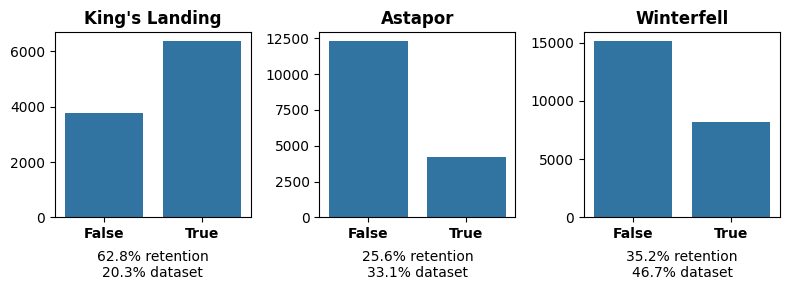

In [26]:
#retention rate by city
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(df1.city.unique()):
    plt.subplot(1,3,i+1)
    #sns.countplot(x=df1[df1.city==c].retained, palette='turbo_r')
    sns.countplot(x=df1[df1.city==c].retained, palette='turbo_r',hue=i,legend=False)
    sns.countplot(x=df1[df1.city==c].retained)
    plt.title(c, fontweight='bold')
    plt.text(0.5,1, f'\n\n{100*df1[df1.city==c].retained.mean():.1f}% retention\n{100*df1[df1.city==c].shape[0]/df1.shape[0]:.1f}% dataset',
             ha='center', va='top')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

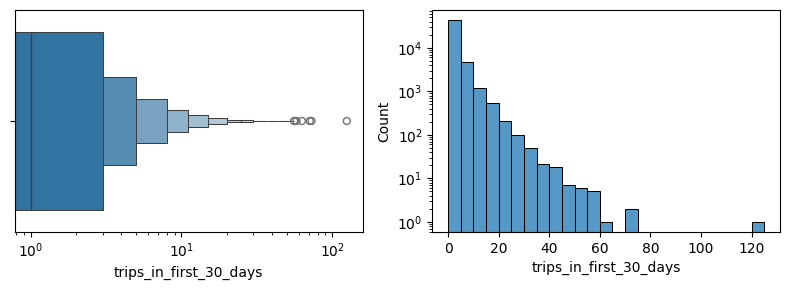

In [27]:
#retention by first month trips
plt.figure(figsize=(8,3), tight_layout=True)
plt.subplot(1,2,1)
sns.boxenplot(x = df1.trips_in_first_30_days)
plt.xscale('log')
plt.subplot(1,2,2)
sns.histplot(x = df1.trips_in_first_30_days, binwidth=5)
plt.yscale('log')

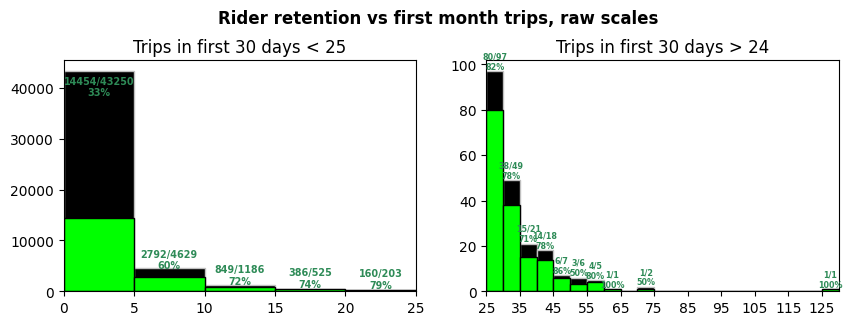

In [28]:
bins = np.arange(0, df1.trips_in_first_30_days.max()+10, 5)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(x = df1[(df1.trips_in_first_30_days<25)].trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = df1[(df1.retained==True)&(df1.trips_in_first_30_days<25)].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.xlim((0,25))
for i,val in enumerate(bins[0:5]):
    rate = df1[df1.trips_in_first_30_days.between(val,bins[i+1], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(bins[i+1]-2.5, rate.sum()*0.88, 
                 f'{rate[True]}/{rate.sum()}\n{100*rate[True]/rate.sum():.0f}%', color='seagreen',
                 ha='center', va='bottom', fontsize='x-small', fontweight='bold')
plt.title('Trips in first 30 days < 25')
plt.subplot(122)
plt.hist(x = df1[(df1.trips_in_first_30_days>=25)].trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = df1[(df1.retained==True)&(df1.trips_in_first_30_days>=25)].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.xlim((25,130))
plt.xticks(np.arange(25,130,10))
for i,val in enumerate(bins[5:-1]):
    rate = df1[df1.trips_in_first_30_days.between(val,bins[i+6], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(bins[i+6]-2.5, rate.sum(), 
                 f'{rate[True]}/{rate.sum()}\n{100*rate[True]/rate.sum():.0f}%', color='seagreen',
                 ha='center', va='bottom', fontsize='xx-small', fontweight='bold')
plt.title('Trips in first 30 days > 24')
plt.suptitle('Rider retention vs first month trips, raw scales', y=1.05, fontweight='bold')
plt.show()

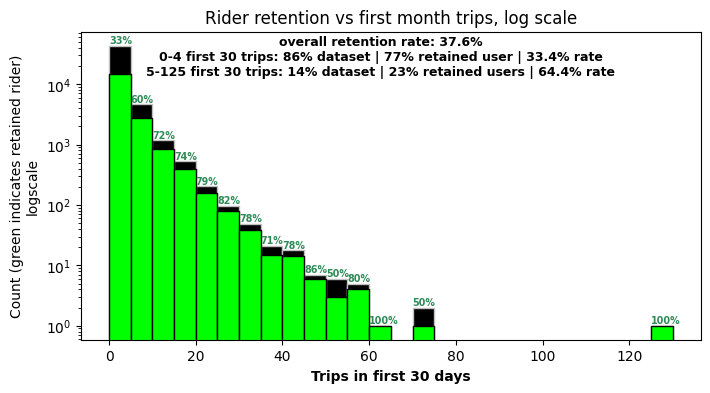

In [29]:
bins = np.arange(0, df1.trips_in_first_30_days.max()+10, 5)

plt.figure(figsize=(8,4))
plt.hist(x = df1.trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = df1[df1.retained==True].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.yscale('log')

for i,val in enumerate(bins[:-1]):
    rate = df1[df1.trips_in_first_30_days.between(val,bins[i+1], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(val, rate.sum(), f'{100*rate[True]/rate.sum():.0f}%', color='seagreen',
             ha='left', va='bottom', fontsize='x-small', fontweight='bold')
plt.title("Rider retention vs first month trips, log scale")
plt.suptitle(f'overall retention rate: {100*df1.retained.sum()/df1.shape[0]:.1f}%\n\
0-4 first 30 trips: {100*df1[df1.trips_in_first_30_days.between(0,4)].shape[0]/df1.shape[0]:.0f}% dataset | \
{100*df1[df1.trips_in_first_30_days.between(0,4)].retained.sum()/df1.retained.sum():.0f}% retained user | \
{100*df1[df1.trips_in_first_30_days.between(0,4)].retained.sum()/df1[df1.trips_in_first_30_days.between(0,4)].shape[0]:.1f}% rate\n\
5-125 first 30 trips: {100*df1[df1.trips_in_first_30_days>4].shape[0]/df1.shape[0]:.0f}% dataset | \
{100*df1[df1.trips_in_first_30_days>4].retained.sum()/df1.retained.sum():.0f}% retained users | \
{100*df1[df1.trips_in_first_30_days>4].retained.sum()/df1[df1.trips_in_first_30_days>4].shape[0]:.1f}% rate',
             y=0.87,
             fontsize=9, fontweight='bold')
plt.xlabel("Trips in first 30 days", fontweight='bold')
plt.ylabel("Count (green indicates retained rider)\nlogscale")
plt.show()


/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6247/1652212390.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[df1.ultimate_black_user==c].retained, palette='turbo_r')
/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6247/1652212390.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[df1.ultimate_black_user==c].retained, palette='turbo_r')


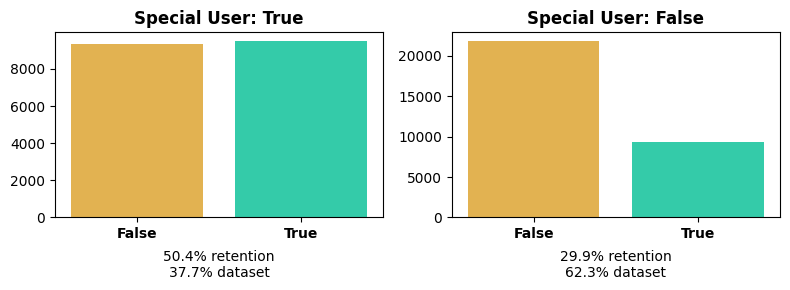

In [30]:
#retention rate for special users
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(df1.ultimate_black_user.unique()):
    plt.subplot(1,2,i+1)
    sns.countplot(x=df1[df1.ultimate_black_user==c].retained, palette='turbo_r')
    plt.title(f'Special User: {c}', fontweight='bold')
    plt.text(0.5,1, f'\n\n{100*df1[df1.ultimate_black_user==c].retained.mean():.1f}% retention\n{100*df1[df1.ultimate_black_user==c].shape[0]/df1.shape[0]:.1f}% dataset',
             ha='center', va='top')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6247/388611848.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[df1.phone==c].retained, palette='turbo_r')
/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6247/388611848.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[df1.phone==c].retained, palette='turbo_r')
/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6247/388611848.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df1[df1.phone.isna()].retained, palette='turbo_r')


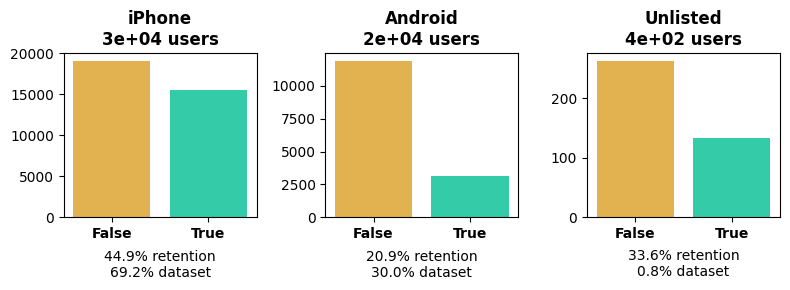

In [31]:
#retention rate by phone
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(df1.phone.unique()):
    plt.subplot(1,3,i+1)
    if c == None:
        sns.countplot(x=df1[df1.phone.isna()].retained, palette='turbo_r')
        plt.text(0.5,1, f'\n\n{100*df1[df1.phone.isna()].retained.mean():.1f}% retention\n{100*df1[df1.phone.isna()].shape[0]/df1.shape[0]:.1f}% dataset',
                 ha='center', va='top')
        plt.title(f'Unlisted\n{df1[df1.phone.isna()].shape[0]:.0e} users', fontweight='bold')
    else:
        sns.countplot(x=df1[df1.phone==c].retained, palette='turbo_r')
        plt.text(0.5,1, f'\n\n{100*df1[df1.phone==c].retained.mean():.1f}% retention\n{100*df1[df1.phone==c].shape[0]/df1.shape[0]:.1f}% dataset',
                 ha='center', va='top')
        plt.title(f'{c}\n{df1[df1.phone==c].shape[0]:.0e} users', fontweight='bold')

    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

<Axes: >

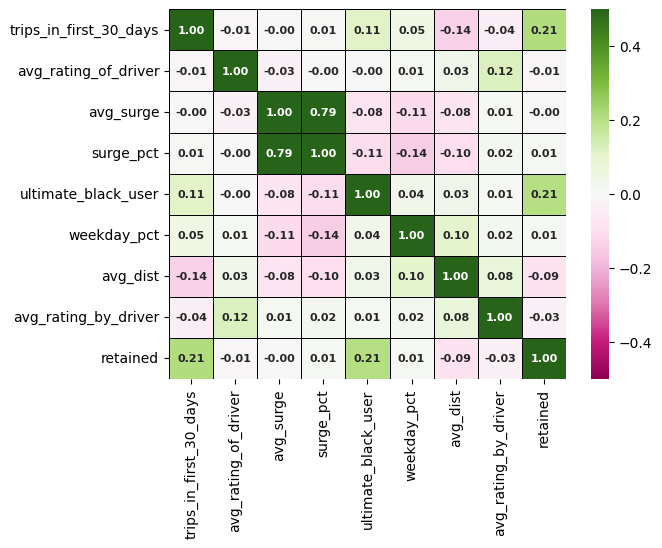

In [32]:
#features and target correlations
sns.heatmap(df1.corr(numeric_only=True), cmap='PiYG', linecolor='k', linewidths=0.5,
           vmin=-0.5, vmax=0.5,yticklabels=True, xticklabels=True, fmt=".2f",
           annot=True, annot_kws=dict(fontsize=8,fontweight='bold'))

Data Prep
Logistic regression model to predict retainment

- feature adjustments
    encode categorical text data
            city, phone
    drop date features
            no obvious relationships between signup and target
            last_trip used to define target
    drop rating columns
            no obvious relationships between ratings and target
            missing data
    avg surge vs surge pct = "users lifetime avg surge multiplier" vs "users lifetime percent trips with surge rates"
            surge pct higher R2, both are very low
            multiplying two increases R2 by factor of 4, still very low
                    combine into surge and drop originals
      dtypes
            change ultimate_black_user from boolean to int
            not needed, but convenient for using df index for normalization
- z-score normalization
    numerical columns only: ['trips_in_first_30_days','weekday_pct','avg_dist','surge']
surge feature engineering --> choose highest R2 with target

In [33]:
print(f'Surge Pct R2: {df1.retained.corr(df1.surge_pct)**2:.2e}')
print(f'Surge Avg R2: {df1.retained.corr(df1.avg_surge)**2:.2e}')
print(f'Pct*Avg combo: {df1.retained.corr(df1.surge_pct*df1.avg_surge)**2:.2e}')

Surge Pct R2: 1.39e-04
Surge Avg R2: 1.11e-05
Pct*Avg combo: 5.71e-04


In [34]:
#data1=df1.copy()
data1=df1

In [35]:
data1.columns


Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained'],
      dtype='object')

# Encode Categorical Features
# Encode, add encoded, drop original cities
enc = OneHotEncoder()
enc.fit(data1.city.values.reshape(-1,1))
enc.sparse_output=False
# enc.categories_
new = enc.transform(data1.city.values.reshape(-1,1))
for i,col in enumerate(enc.categories_[0]):
    data1.loc[:,f'city_{col}'] = new[:,i]
data1.drop(columns='city', inplace=True)

# Encode, add encoded, drop original phones
enc = OneHotEncoder()
enc.fit(data1.phone.values.reshape(-1,1))
enc.sparse_output=False
enc.categories_
new = enc.transform(data1.phone.values.reshape(-1,1))
for i,col in enumerate(enc.categories_[0]):
    data1.loc[:,f'phone_{col if col else "unlisted"}'] = new[:,i]
data1.drop(columns='phone', inplace=True)

In [36]:
#import pandas as pd
#pd.get_dummies(data1,prefix=['city','phone']
#dummy_cols = pd.get_dummies(data1,prefix=['city','phone'],drop_first=True)
dummy_cols = pd.get_dummies(df1,columns=['city','phone'])

In [37]:
data1=pd.concat([data1,dummy_cols],axis=1)

In [38]:
data1.drop(['city','phone'],axis=1,inplace=True)

In [39]:
data1.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained',
       'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [40]:
data1.drop(columns=['avg_rating_of_driver', 'avg_rating_by_driver',
                    'signup_date', 'last_trip_date'], inplace=True)

# combine surge into one feature
#data1.loc[:,'surge'] = data1.surge_pct*data1.avg_surge
#data1.drop(columns=['avg_surge','surge_pct'], inplace=True)

# convert special user to int from bool
#data1.loc[:,'special_user'] = data1.ultimate_black_user.astype(int)
#data1.drop(columns='ultimate_black_user', inplace=True)
data1['ultimate_black_user']=data1['ultimate_black_user'].astype(int)

In [41]:
data1.sample(5)

,trips_in_first_30_days,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,retained,trips_in_first_30_days,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
14234,1,1.19,25.0,1,25.0,1.91,True,1,1.19,25.0,1,25.0,1.91,True,False,True,False,False,True
6927,0,1.00,0.0,1,80.0,4.14,True,0,1.00,0.0,1,80.0,4.14,True,True,False,False,False,True
22911,1,1.00,0.0,0,100.0,14.69,False,1,1.00,0.0,0,100.0,14.69,False,False,True,False,False,True
37451,4,1.00,0.0,1,71.4,7.24,True,4,1.00,0.0,1,71.4,7.24,True,True,False,False,False,True
22989,3,1.13,18.8,1,66.7,4.51,True,3,1.13,18.8,1,66.7,4.51,True,False,False,True,False,True
